# MNIST by Variational AutoEncoder written in PyTorch

In [1]:
!lspci | grep VGA  # グラフィックボード("Geforce"や"Quadro"が出てこなかったら，$ sudo update-pciids)
!which jupyter # (仮想)環境
!python --version # python

#import tensorflow
#print('tensorflow ' + tensorflow.__version__) # tensorflow

import torch
print('torch ' + torch.__version__) # torch
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is unavailable.")

!nvcc -V | grep release # cuda
!nvidia-smi | grep -i "CUDA Version" # cuda

09:00.0 VGA compatible controller: NVIDIA Corporation TU104 [GeForce RTX 2070 SUPER] (rev a1)
/home/kitamoto/anaconda3/envs/py3p8-torch1p8-cuda10p2/bin/jupyter
Python 3.8.10
torch 1.8.1
GPU is available.
Cuda compilation tools, release 11.2, V11.2.152
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
sns.set()

In [2]:
path_Data = '../../Data/DigitRecognizer/'
train_df = pd.read_csv(path_Data+"train.csv")

In [3]:
# ラベル分割
x_train = train_df.drop('label', axis=1)
y_train = train_df['label']

In [4]:
print(x_train.shape, y_train.shape)
print(type(x_train), type(y_train))

(42000, 784) (42000,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [5]:
# DataFrameをndarrayに変換
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [6]:
print(x_train.shape, y_train.shape)
print(type(x_train), type(y_train))

(42000, 784) (42000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
# 正規化
x_train = x_train / 255

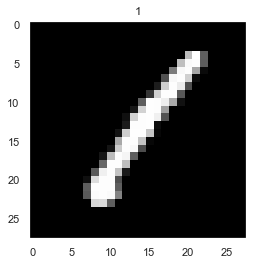

In [8]:
# ndarray画像の表示(最初の1枚)

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(y_train[0])
plt.grid(False) # 軸目盛りの表示
plt.show()

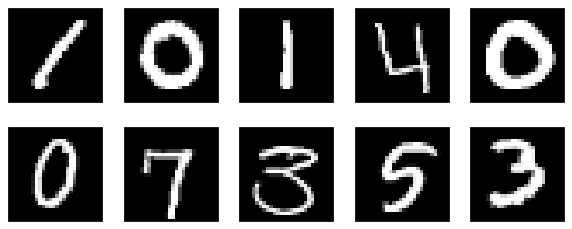

In [10]:
# ndarray画像の表示(10枚)

n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="Greys_r") # グレースケール
    ax.get_xaxis().set_visible(False)  # 軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
img_size = 28  # 画像の高さと幅
n_in_out = img_size * img_size  # 入出力層のニューロン数 28×28=784
n_mid = 64  # 中間層のニューロン数

n_z = 2  # 潜在変数の数

batch_size = 16
epochs = 100
interval = 10  # 経過の表示間隔
eta = 0.01  # 学習係数

In [12]:
import torch
from torch.utils.data import DataLoader

x_train = torch.tensor(x_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(x_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_mid = nn.Linear(n_in_out, n_mid)  # Encoderの中間層
        self.enc_mu = nn.Linear(n_mid, n_z)        # 平均値を求める層
        self.enc_logvar = nn.Linear(n_mid, n_z)    # 分散のlogを求める層

        self.dec_mid = nn.Linear(n_z, n_mid)       # Decoderの中間層
        self.dec_out = nn.Linear(n_mid, n_in_out)  # Decoderの出力層

    def forward(self, x):
        z = self.encode(x)
        y = self.decode(z)
        return y

    def encode(self, x):
        x = x.view(-1, n_in_out)

        x = torch.relu(self.enc_mid(x))
        self.mu = self.enc_mu(x)
        self.logvar = self.enc_logvar(x)

        std = torch.exp(0.5*self.logvar)  #標準偏差
        eps = torch.randn_like(std)       #正規分布に従う乱数
        return self.mu + std*eps          #潜在変数(reparametrization trick)

    def decode(self, z):
        x = torch.relu(self.dec_mid(z))
        x = torch.sigmoid(self.dec_out(x))
        return x

    def loss(self, y, x):
        x = x.view(-1, n_in_out)
                                  
        rec_loss = F.binary_cross_entropy(y, x, reduction="sum")  #再構成誤差
        reg_loss = 0.5 * torch.sum(self.mu**2 + torch.exp(self.logvar)- self.logvar - 1)  #正則化項
        return (rec_loss, reg_loss)

vae = VAE()
vae.cuda()  # GPU対応
print(vae)

VAE(
  (enc_mid): Linear(in_features=784, out_features=64, bias=True)
  (enc_mu): Linear(in_features=64, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=64, out_features=2, bias=True)
  (dec_mid): Linear(in_features=2, out_features=64, bias=True)
  (dec_out): Linear(in_features=64, out_features=784, bias=True)
)


In [14]:
%%time

from torch import optim
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

# 学習
for i in range(epochs):
    vae.train()  # 訓練モード
    loss_rec = 0
    loss_reg = 0
    loss_total = 0

    for j, (x,) in enumerate(train_loader):  # ミニバッチ（x,）を取り出す
        x = x.cuda()  # GPU対応
        y = vae(x)
        lrec, lreg = vae.loss(y, x)
        loss = lrec + lreg
        loss_rec += lrec.item()
        loss_reg += lreg.item()
        loss_total += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_rec /= j+1
    loss_reg /= j+1
    loss_total /= j+1
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    if i%interval == 0:
        print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 2850.7557861793157 Loss_Reg: 89.99937453092848 Loss_Total: 2940.7551624813987
Epoch: 10 Loss_Rec: 2423.4572603236606 Loss_Reg: 89.5770792061942 Loss_Total: 2513.034337983631
Epoch: 20 Loss_Rec: 2372.509106073289 Loss_Reg: 92.92989039539155 Loss_Total: 2465.438997442336
Epoch: 30 Loss_Rec: 2348.568984747024 Loss_Reg: 94.4093123953683 Loss_Total: 2442.978296921503
Epoch: 40 Loss_Rec: 2331.1291645740325 Loss_Reg: 95.86771610804966 Loss_Total: 2426.996879464286
Epoch: 50 Loss_Rec: 2317.9354953031993 Loss_Reg: 96.84091693115235 Loss_Total: 2414.776411783854
Epoch: 60 Loss_Rec: 2307.117900111607 Loss_Reg: 97.66342780994233 Loss_Total: 2404.781326590402
Epoch: 70 Loss_Rec: 2299.2967042875744 Loss_Reg: 98.81088029261998 Loss_Total: 2398.107583193824
Epoch: 80 Loss_Rec: 2292.5262001023066 Loss_Reg: 98.86691723923457 Loss_Total: 2391.3931186290924
Epoch: 90 Loss_Rec: 2286.0891409040178 Loss_Reg: 99.21005967494419 Loss_Total: 2385.2992002418155
CPU times: user 8min 52s, sys: 1.

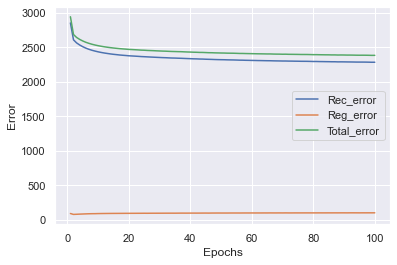

In [15]:
plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 再構成誤差(Rec_error)と正則化項(Reg_error)が均衡し，全体の誤差(Total_error)が動かなくなることが確認できる．
# 潜在変数は範囲を広げることで入出力を一致させようとするが，これを正則化項が抑制していることになる．

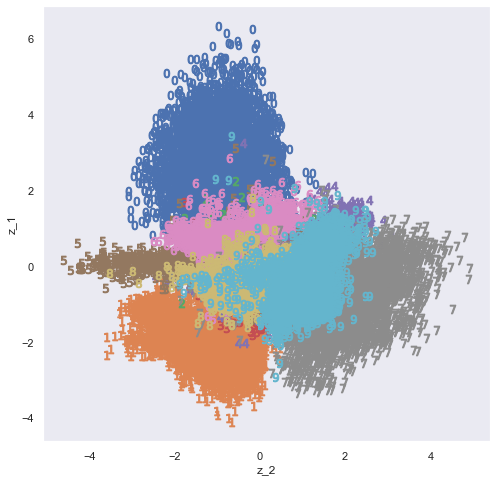

In [16]:
# 潜在空間の可視化
# 潜在変数を2としたため，潜在空間を2D平面で可視化できる．
# 入力画像はそれが何の数であるかを示すラベルとペアになっているので，このラベルを文字として潜在空間にプロットする．

# 潜在変数を計算
vae.eval()  #評価モード
x = x_train.cuda()
z = vae.encode(x)  #潜在変数
z = z.cpu().detach().numpy() #ndarrayに変換

t = y_train  #ラベル

# 潜在変数を平面にプロット
plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z[t==i]
    z_1 = zt[:, 0]  # y軸
    z_2 = zt[:, 1]  # x軸
    marker = "$"+str(i)+"$"  # 数値をマーカーに
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.grid()
plt.show()


# 入力画像のラベルによって，潜在空間内にプロットされる位置が決まってくる．
# VAEは入力を潜在空間に割り当てるように学習する．

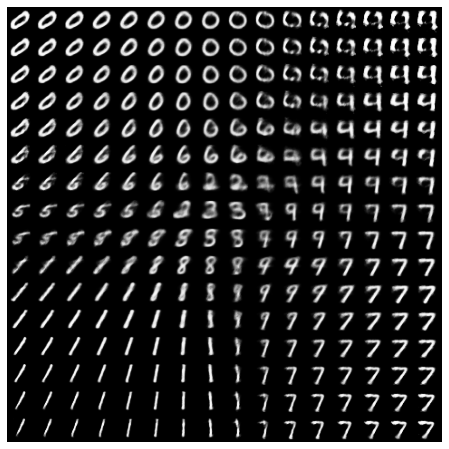

In [17]:
# 訓練済みVAEのDecoderを使って，画像を生成
# 潜在変数を連続的に変化させて，生成される画像がどのように変化するのかを確認

# 画像の設定
n_img = 16  # 画像を16x16並べる
img_size_spaced = img_size + 2
matrix_image = np.zeros((img_size_spaced*n_img, img_size_spaced*n_img))  # 全体の画像

# 潜在変数
z_1 = np.linspace(3, -3, n_img)  # 行
z_2 = np.linspace(-3, 3, n_img)  # 列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        z = torch.tensor([[z1, z2]], dtype=torch.float)
        z = z.cuda()
        y = vae.decode(z)  # Decoder
        y = y.cpu().detach().numpy()
        image = y.reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+img_size, left : left+img_size] = image

plt.figure(figsize=(8, 8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.axis('off') # 目盛りは非表示
plt.show()

# たった2つの潜在変数に，画像を圧縮できたことになる．
# データの特徴を少数の潜在変数に圧縮できて，潜在変数が生成データに与える影響が明瞭となるのがVAEの特徴
# 潜在変数の分布が人間にとっても直感的で分かりやすく，潜在変数を変化させると，出力にどのように影響するのかが分かりやすい．